In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing the necessary libraries
import sys
import cv2
import torch
import torchvision
import numpy as np 
import pandas as pd
from torch import nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split

In [3]:
# Drive path and printing head
df = pd.read_csv('/content/drive/MyDrive/DeepLearning_Dataset/Train.csv')

In [4]:
df.tail(10)

OriginalImages             AnnotatedImages
118  DL_Images/119.png  DL_AnnotatedImages/119.png
119  DL_Images/120.png  DL_AnnotatedImages/120.png
120  DL_Images/121.png  DL_AnnotatedImages/121.png
121  DL_Images/122.png  DL_AnnotatedImages/122.png
122  DL_Images/123.png  DL_AnnotatedImages/123.png
123  DL_Images/124.png  DL_AnnotatedImages/124.png
124  DL_Images/125.png  DL_AnnotatedImages/125.png
125  DL_Images/126.png  DL_AnnotatedImages/126.png
126  DL_Images/127.png  DL_AnnotatedImages/127.png
127  DL_Images/128.png  DL_AnnotatedImages/128.png

In [6]:
#splitting the data into training,testing and validation datasets

train_data, val_data, test_data = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])


In [7]:
def mask_to_class_rgb(mask):
    color_dict={
    0: (0, 0, 0),  # Background
    1: (250,250,55),  # Class 1 represents Person
    2: (255,0,124),   # Class 2 represents Furniture
    3: (50,183,250),  # Class 3 represents Building
    4: (255,106,77),  # Class 4 represents Car
    5: (61,61,245),   # Class 5 represents Pole
    }
    mask = mask.detach().cpu().numpy() if isinstance(mask, torch.Tensor) else mask
    # Creating a new numpy array
    image_height, image_width = tensor.shape
    color_mask = np.zeros((image_height, image_width, 3), dtype=np.uint8)

    for row in range(image_height):
        for column in range(image_width):
            color_index = mask[0][row][column]
            color_mask[row][column] = color_dict[color_index]

    return color_mask
        
def index_mask_class(mask):

    color_to_class_dict = {
      (0, 0, 0): 0,      # Black pixel represents background
      (250,250,55): 1,   # Represents Person
      (255,0,124):  2,   # Represents Furniture
      (50,183,250): 3,   # Represents Building
      (255,106,77): 4,   # Represents Car
      (61,61,245):  5,   # Represents Pole
    }

  
    mask_image = Image.open(mask)
    mask_image = mask_image.resize((320, 320))
    mask_array = np.array(mask_image)
    class_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)
    for color, class_idx in color_to_class_dict.items():
        color_indices = np.where(np.all(mask_array == color, axis=-1))
        class_indices[color_indices] = class_idx
    return class_indices



In [8]:
class CustomImageDataset(Dataset):
    
    def __init__(self, df):
        
        self.df=df
        self.transforms = transforms.Resize((320, 320))
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self ,idx):
        row = self.df.iloc[idx]
        dir_path = "/content/drive/MyDrive/DeepLearning_Dataset/"
        image_path = dir_path+row.OriginalImages
        AnnotatedImage_path  =  dir_path+row.AnnotatedImages
        # Load the image and mask as PIL images
        image = Image.open(image_path).convert("RGB")
        mask_img = index_mask_class(AnnotatedImage_path)
        mask_img = np.expand_dims(mask_img ,axis=-1)#(h,w,1)
        # Transpose the image and mask tensors from (h,w,c) to (c,h,w) and convert them to float32 type
        image = np.transpose(image ,(2,0,1)).astype(np.float32)
        mask_img = np.transpose(mask_img ,(2,0,1)).astype(np.float32)
        # Apply the image transformation and normalize the resulting tensor to [0,1] range
        image = self.transforms(torch.Tensor(image)) # Reshaping the image
        image = image/255.0 # normalizing original image tensor [0,1] range
        return image, torch.Tensor(mask_img)

In [9]:
train_dataSet, valid_dataSet, test_dataSet = [CustomImageDataset(data) for data in [train_data, val_data, test_data]]


In [10]:
#Splitting the data in batch wise
train_dataLoader, val_dataLoader, test_dataLoader = [DataLoader(dataset, batch_size=8, shuffle=True) 
                                                    for dataset in [train_dataSet, valid_dataSet, test_dataSet]]


In [11]:
print(f"Total batches in train data loader: {len(train_dataLoader)}")
print(f"Total batches in validation data loader: {len(val_dataLoader)}")
print(f"Total batches in test data loader: {len(test_dataLoader)}")


Total batches in train data loader: 13
Total batches in validation data loader: 2
Total batches in test data loader: 2


In [12]:

# Get one batch of images and masks from the train data loader
image, mask = next(iter(train_dataLoader))

# Print the shape of the batch of images
print('One batch image shape: {}'.format(image.shape))

# Print the shape of the batch of masks
print('One batch mask shape: {}'.format(mask.shape))



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


One batch image shape: torch.Size([8, 3, 320, 320])
One batch mask shape: torch.Size([8, 1, 320, 320])


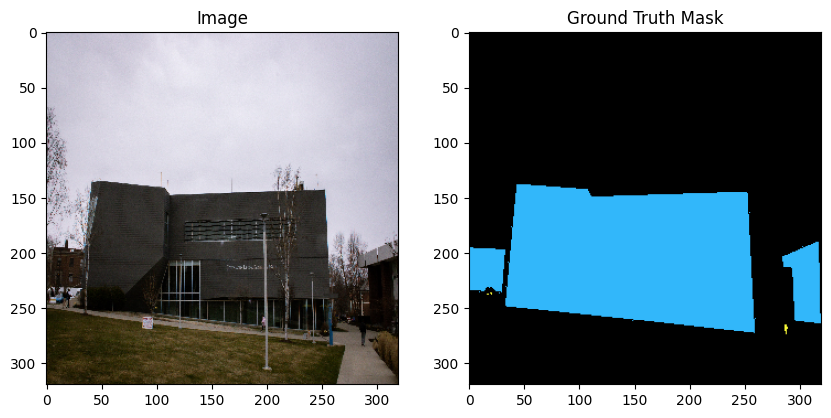

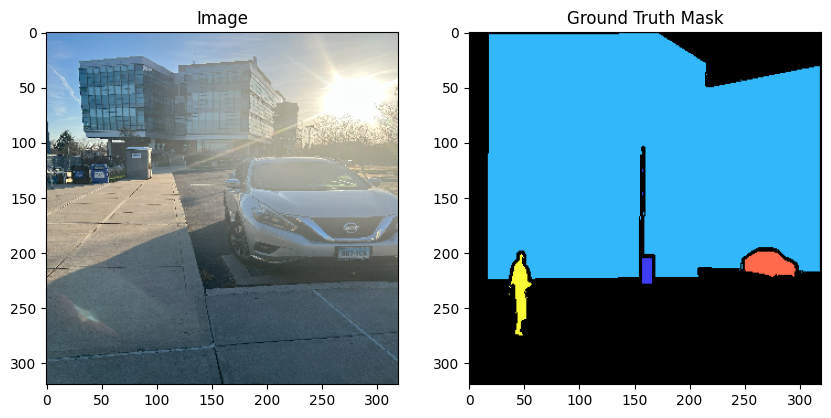

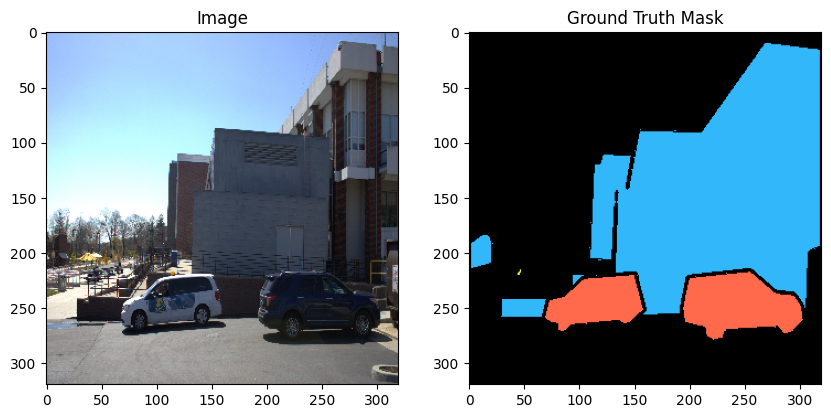

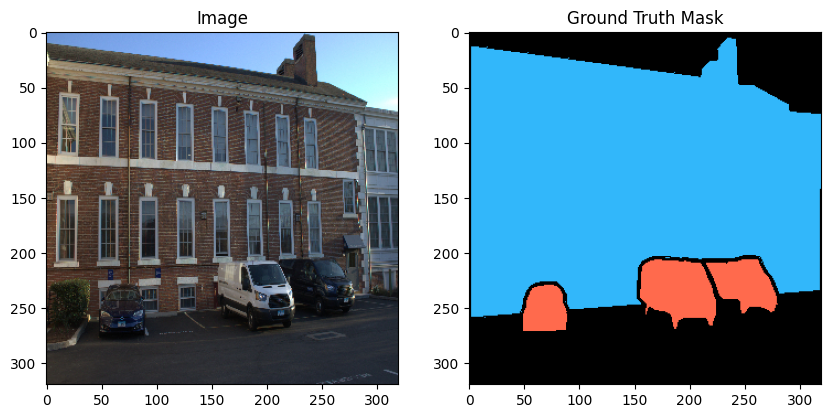

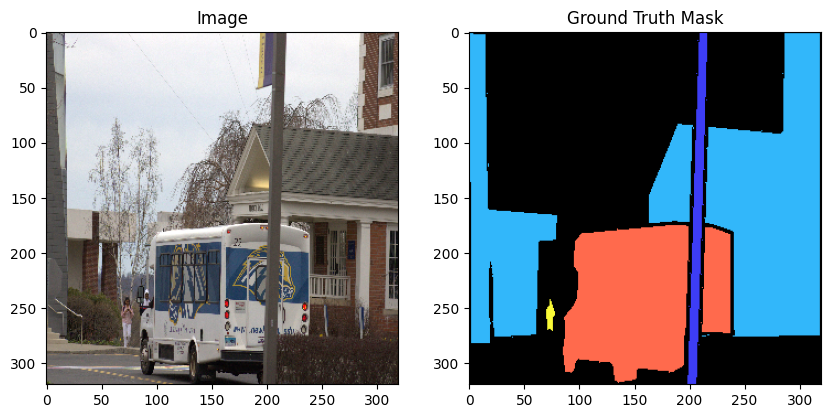

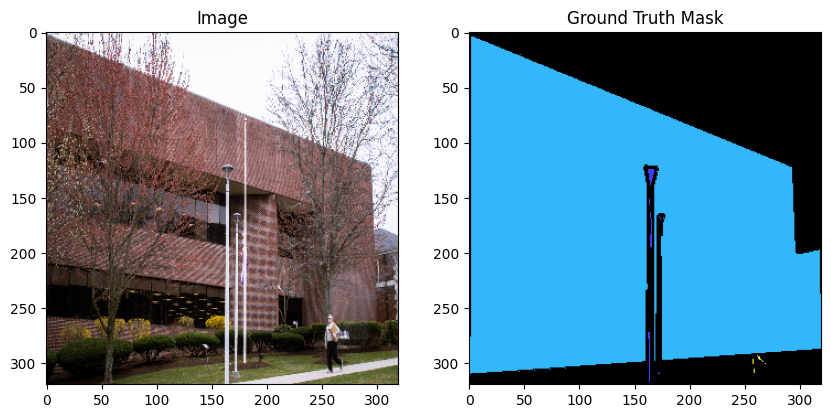

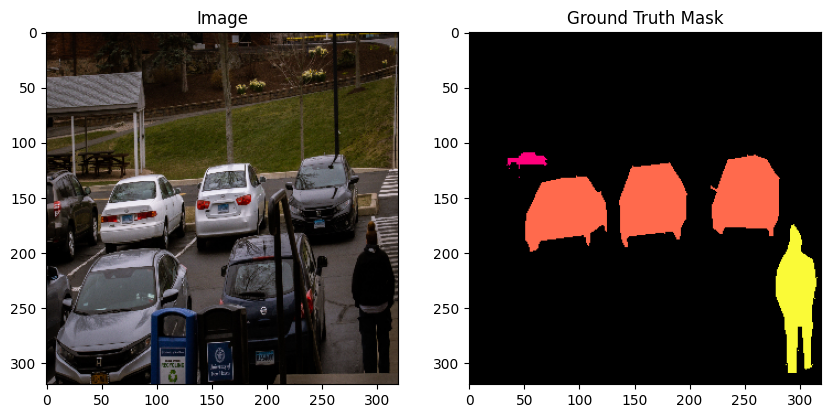

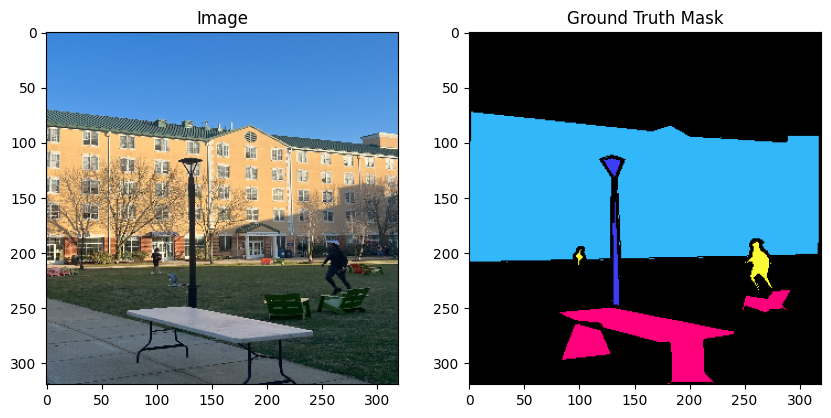

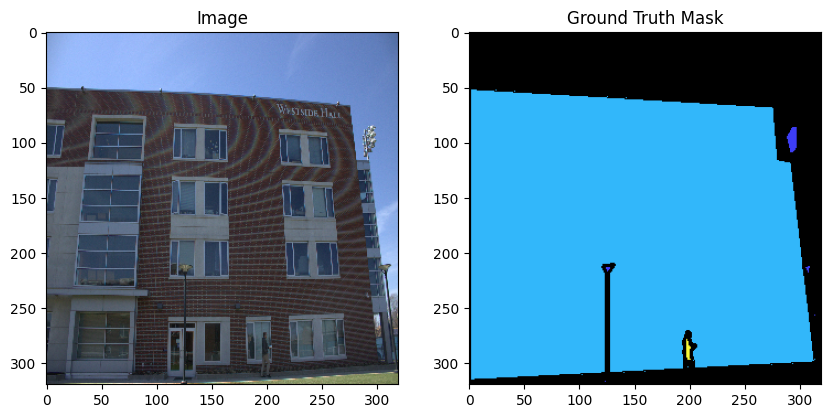

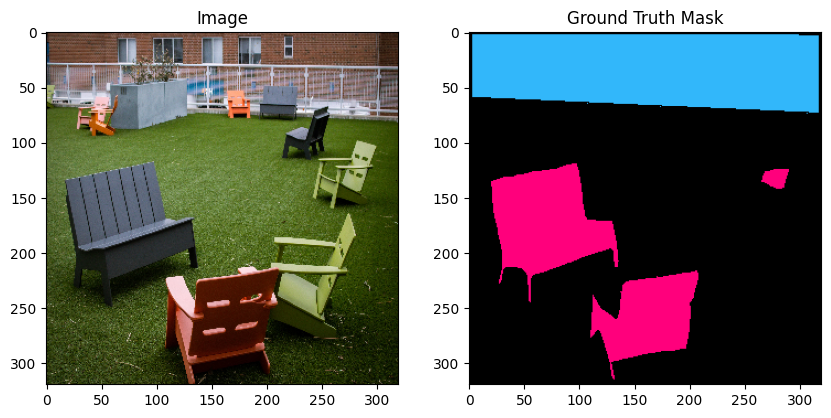

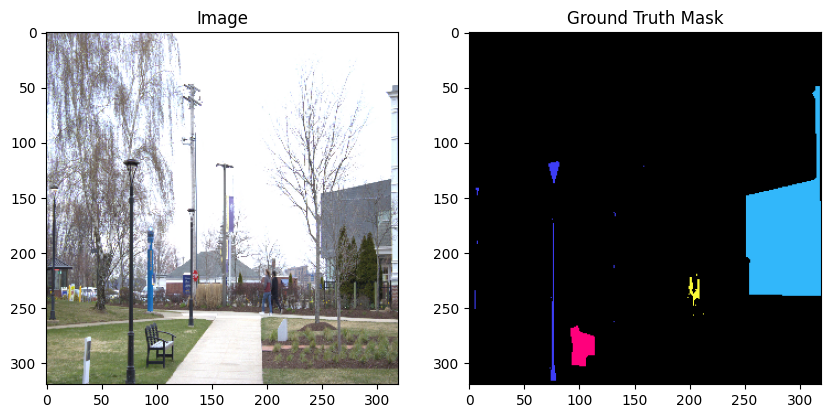

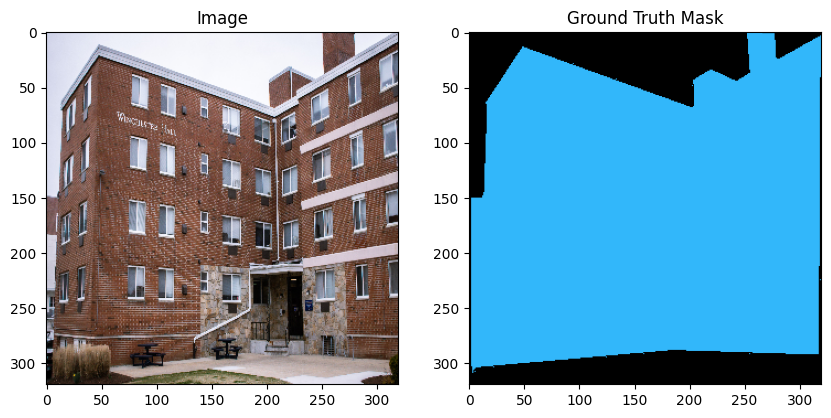

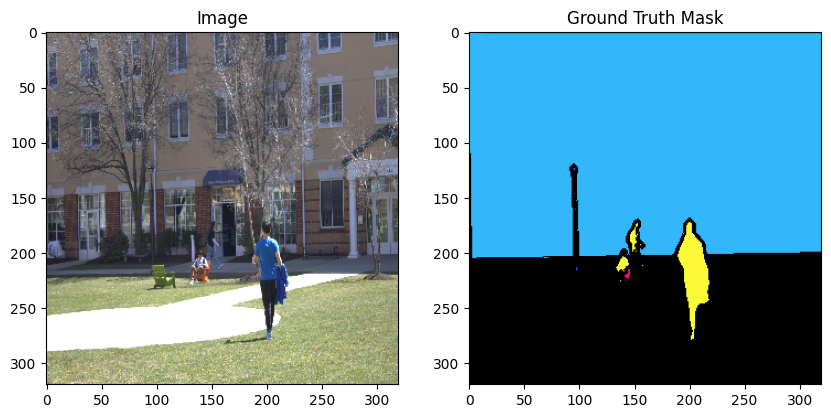

In [13]:

for orig_images, masked_images in train_dataLoader:
    fig, (ax_image, ax_ground_truth) = plt.subplots(1, 2, figsize=(10, 5))
    ax_image.set_title("Image")
    ax_ground_truth.set_title("Ground Truth Mask")

    #plotting the original image
    ax_image.imshow(orig_images[0].permute([1,2,0]).numpy())

    #Plotting the Masked image
    ax_ground_truth.imshow(mask_to_class_rgb(masked_images[0]))

    plt.show()

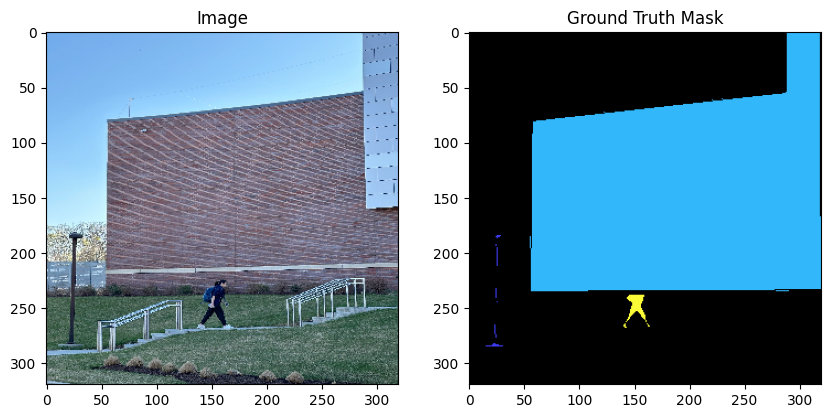

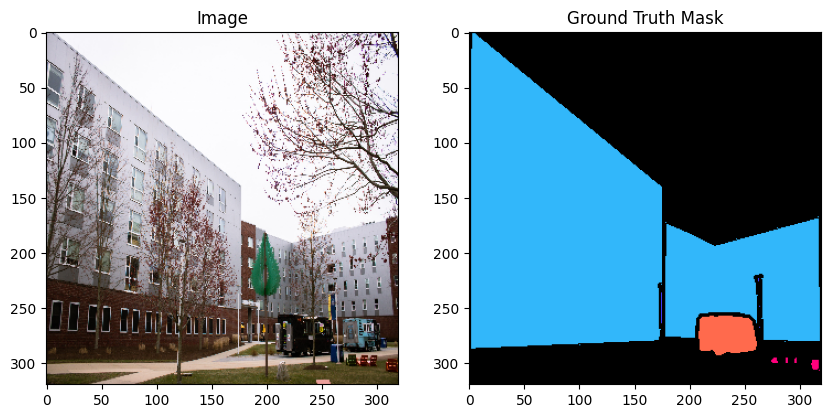

In [14]:

# Displaying one image from each batch in Val_dataLoader

for orig_images, masked_images in val_dataLoader:
    fig, (ax_image, ax_ground_truth) = plt.subplots(1, 2, figsize=(10, 5))
    ax_image.set_title("Image")
    ax_ground_truth.set_title("Ground Truth Mask")

    #plotting the original image
    ax_image.imshow(orig_images[0].permute([1,2,0]).numpy())

    #Plotting the Masked image
    ax_ground_truth.imshow(mask_to_class_rgb(masked_images[0]))

    plt.show()

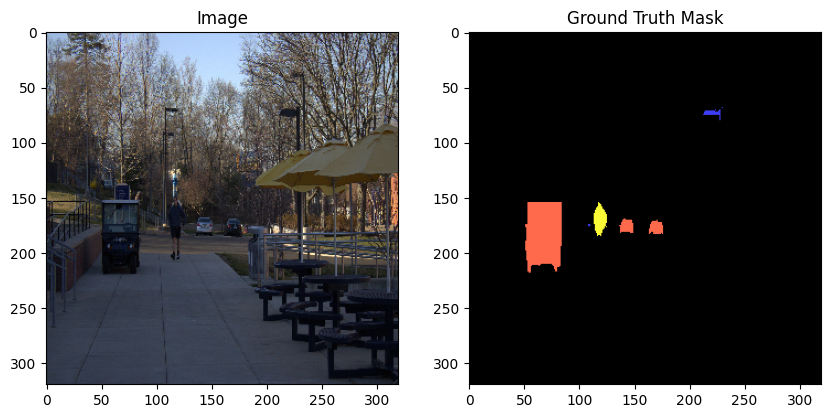

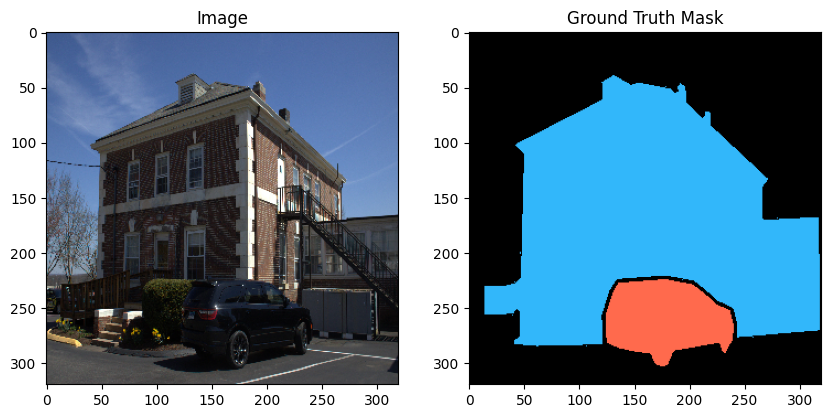

In [15]:
#Displaying one image from each batch in test_dataLoader

for orig_images, masked_images in test_dataLoader:
    fig, (ax_image, ax_ground_truth) = plt.subplots(1, 2, figsize=(10, 5))
    ax_image.set_title("Image")
    ax_ground_truth.set_title("Ground Truth Mask")

    #plotting the original image
    ax_image.imshow(orig_images[0].permute([1,2,0]).numpy())

    #Plotting the Masked image
    ax_ground_truth.imshow(mask_to_class_rgb(masked_images[0]))

    plt.show()

In [16]:

#configurations
ENCODER = 'resnet50'
WEIGHTS = 'imagenet'
DEVICE = 'cuda'

In [17]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=cb2a9e9e4b3fb4335d0cae1eb551b2fc6734f8fd785e081da511516f3479f1c2
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=063c1278736701d1de831c00e46f7c2396ca9d56156f328c22674092c6144ad6
  Stored in directory: /root/.cache/pip/w

In [18]:
import segmentation_models_pytorch as smp

In [19]:
def loss_calculation(pred_mask, mask):
    masks = masks.squeeze(1)
    self.criterion = nn.CrossEntropyLoss()
    loss = self.criterion(pred_mask, masks)
    return loss

class DeepLabV3PlusModel(nn.Module):
    def __init__(self):
        super(DeepLabV3PlusModel, self).__init__()

        self.deep = smp.DeepLabV3Plus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=6,
            activation='softmax'
        )

    def forward(self, images, masks=None):
        pred_mask = self.deep(images)
        if masks:
            loss = loss_calculation
            return pred_mask, loss
        return pred_mask


In [20]:
model = DeepLabV3PlusModel()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.4MB/s]


DeepLabV3PlusModel(
  (arc): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (

In [21]:

def train_model(data_loader, deep_model, optimizer):
    # Set the model to train mode
    deep_model.train()

    # Initializing the total loss to zero
    model_loss = 0

    # Create a progress bar with the description "Training" and leave as False
    progress_bar = tqdm(data_loader, desc='Training', leave=False)

    # Loop over the data in the data loader
    for i, (images, masks) in enumerate(progress_bar):
        # Move images and masks to the device
        images = images.to(DEVICE)
        masks = masks.to(DEVICE).long()

        # Reset the gradients to zero
        optimizer.zero_grad()

        # Forward pass to get the logits and loss
        pred_mask, loss = deep_model(images, masks)

        # Compute gradients and backpropagate the loss
        loss.mean().backward()
        optimizer.step()

        # Update the total loss
        model_loss = model_loss + loss.item()

        # Updating the progress bar with the current training loss
        progress_bar.set_postfix({'Training loss': model_loss / (i + 1)})

    # Return the average training loss
    return model_loss / len(data_loader)


def eval_model(data_loader, deep_model):
    # Setting the model to evaluation mode
    deep_model.eval()

    # Initialize total loss to zero
    model_loss = 0

    # Create a progress bar with the description "Evaluating" and leave as False
    progress_bar = tqdm(data_loader, desc='Evaluating', leave=False)

    # Disable gradient computation
    with torch.no_grad():
        # Loop over the data in the data loader
        for i, (images, masks) in enumerate(progress_bar):
            # Move images and masks to the device
            images = images.to(DEVICE)
            masks = masks.to(DEVICE).long()

            # Forward pass to get the logits and loss
            pred_mask, loss = model(images, masks)

            # Update the total loss
            model_loss =  model_loss + loss.item()

            # Update the progress bar with the current evaluation loss
            progress_bar.set_postfix({'Evaluation loss': model_loss / (i + 1)})

    # Return the average evaluation loss
    return model_loss / len(data_loader)


In [22]:
def evaluate_test_data(index):
    # Get image and mask from test dataset
    image, mask = test_dataSet[index]
    # print("Image Shape",image.shape())
    # print("Mask Shape",mask.shape())

    # Pass image through model and get logits
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) 

    # Compute predicted mask probabilities using softmax
    predicted_mask_prob = torch.softmax(logits_mask, dim=1)  

    # Get predicted mask by selecting the class with highest probability
    max_values, predicted_mask = torch.max(predicted_mask_prob, dim=1)  

    # Display the original image, true mask, and predicted mask
    fig, (ax_image, ax_ground_truth, ax_model_output) = plt.subplots(1, 3, figsize=(10, 5))

    ax_image.set_title('Image')
    ax_image.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')

    ax_ground_truth.set_title('Ground Truth Mask')
    ax_ground_truth.imshow(mask_to_class_rgb(mask))

    ax_model_output.set_title('Model Output Mask')
    ax_model_output.imshow(mask_to_class_rgb(predicted_mask))


In [23]:
import random
from itertools import product

# Defining the hyperparameters
hyperparams = {
    "learning_rate": [0.001, 0.01, 0.1],
    "betas": [(0.9, 0.999)],
}

# Generate all possible combinations of hyperparameters
search_space = list(product(*hyperparams.values()))

# Setting the initial best validation loss to 1000
best_valid_loss = 1000

# Loop over the hyperparameter combinations and fine-tune the model
for i, hyperparameters in enumerate(search_space):
    print(f"Training model {i+1}/{len(search_space)} with hyperparameters: {hyperparameters}")
    
    # Initializing the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters[0], betas=hyperparameters[1])

    # Loading the pre-trained weights
    pretrained_path = '/content/drive/MyDrive/DeepLearning_Dataset/resnet50-19c8e357.pth'
    model.load_state_dict(torch.load(pretrained_path))
    pretrained_dict = torch.load(pretrained_path)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    # Defining the fine-tuned path
    fine_tuned_path = f'/content/drive/MyDrive/DeepLearning_Dataset/fine_tuned_{i+1}.pth'

    # Training the model for 10 epochs
    for epoch in range(10):
        train_loss = train_model(train_dataLoader , model , optimizer)
        valid_loss = eval_model(val_dataLoader , model )

        if valid_loss < best_valid_loss:
            # Saving the fine-tuned model to the specified path
            torch.save(model.state_dict(), fine_tuned_path)
            print(f"Saved model {i+1} with validation loss: {valid_loss}")
            best_valid_loss = valid_loss

        print(f"Epoch : {epoch+1} train_loss :{train_loss} valid_loss :{valid_loss}")

Training model 1/3 with hyperparameters: (0.001, (0.9, 0.999))


Training:   0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)

Saved model 1 with validation loss: 1.2614423036575317
Epoch : 1 train_loss :1.2006863630734956 valid_loss :1.2614423036575317


Saved model 1 with validation loss: 1.1858882308006287
Epoch : 2 train_loss :1.1887595561834483 valid_loss :1.1858882308006287


Saved model 1 with validation loss: 1.1795397996902466
Epoch : 3 train_loss :1.1699816355338464 valid_loss :1.1795397996902466


Saved model 1 with validation loss: 1.1700350642204285
Epoch : 4 train_loss :1.1728848218917847 valid_loss :1.1700350642204285


Saved model 1 with validation loss: 1.1425395011901855
Epoch : 5 train_loss :1.1551244350580068 valid_loss :1.1425395011901855


Epoch : 6 train_loss :1.1679581495431752 valid_loss :1.165202558040619


Epoch : 7 train_loss :1.158325351201571 valid_loss :1.1540128588676453


Epoch : 8 train_loss :1.1532225608825684 valid_loss :1.1730003356933594


Epoch : 9 train_loss :1.1669211937830999 valid_loss :1.1674314141273499


Epoch : 10 train_loss :1.1588958776914156 valid_loss :1.1658868193626404
Training model 2/3 with hyperparameters: (0.01, (0.9, 0.999))


Epoch : 1 train_loss :1.394416066316458 valid_loss :1.4089162349700928


Epoch : 2 train_loss :1.3314436490719135 valid_loss :1.3665159940719604


Epoch : 3 train_loss :1.2952400996134832 valid_loss :1.372484266757965


Epoch : 4 train_loss :1.2988810447546153 valid_loss :1.3678354620933533


Epoch : 5 train_loss :1.2666892730272734 valid_loss :1.2692520022392273


Epoch : 6 train_loss :1.2715359834524302 valid_loss :1.3222695589065552


Epoch : 7 train_loss :1.2731207884274995 valid_loss :1.4168980121612549


Epoch : 8 train_loss :1.2557841355984027 valid_loss :1.244577169418335


Epoch : 9 train_loss :1.2363318296579213 valid_loss :1.2799282670021057


Epoch : 10 train_loss :1.2349631602947528 valid_loss :1.2269790768623352
Training model 3/3 with hyperparameters: (0.1, (0.9, 0.999))


Epoch : 1 train_loss :1.4166920368488019 valid_loss :1.40756493806839


Epoch : 2 train_loss :1.429290533065796 valid_loss :1.4165045619010925


Epoch : 3 train_loss :1.4322935892985418 valid_loss :1.4022512435913086


Epoch : 4 train_loss :1.432288179030785 valid_loss :1.418888509273529


Epoch : 5 train_loss :1.4312782837794378 valid_loss :1.406710147857666


Epoch : 6 train_loss :1.4310169219970703 valid_loss :1.4160548448562622


Epoch : 7 train_loss :1.429975335414593 valid_loss :1.4062510132789612


Epoch : 8 train_loss :1.4324082411252534 valid_loss :1.4176713228225708


Epoch : 9 train_loss :1.4290288870151227 valid_loss :1.4077454805374146


Epoch : 10 train_loss :1.4304174001400287 valid_loss :1.4284335374832153


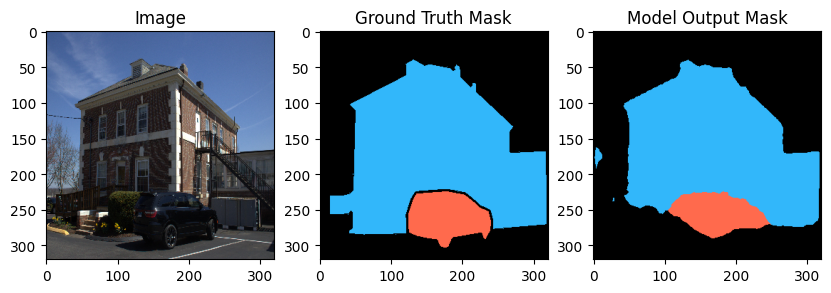

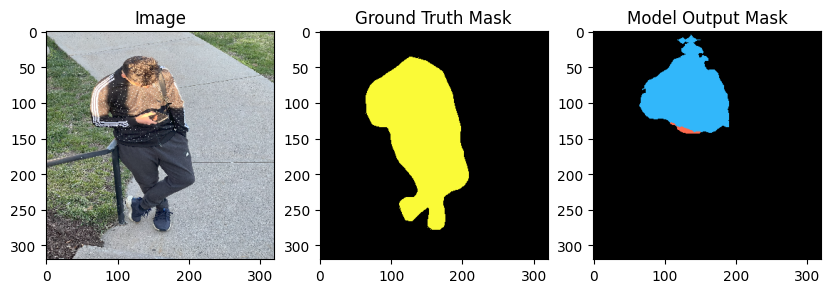

In [53]:
# Evaluating the best model on the test dataset
import random

best_model_path = f'/content/drive/MyDrive/DeepLearning_Dataset/fine_tuned_2.pth'
# Load the saved model parameters
model_params = torch.load(best_model_path, map_location=torch.device('cuda'))

model.load_state_dict(model_params)

for index in random.sample(list(range(len(test_dataSet))), 2):

    evaluate_test_data(index)

In [25]:
def list_normalize(lst):
    return [(x - min(lst)) / (max(lst) - min(lst)) for x in lst]

def calc_iou(predictions, targets):
    iou_scores = []
    for prediction, target in zip(predictions, targets):
        prediction = prediction.flatten()
        target = target.flatten()
        intersection = np.sum(prediction * target)
        union = np.sum((prediction + target) > 0)
        iou = intersection / union
        iou_scores.append(iou)
    normalized_iou_scores = list_normalize(iou_scores)
    mean_iou_score = np.mean(normalized_iou_scores)
    return mean_iou_score

In [26]:

predicted_masks = []
true_masks = []

with torch.no_grad():
    for image, mask in test_dataSet:
        logits_mask = model(image.to(DEVICE).unsqueeze(0))
        pred_mask_prob = torch.softmax(logits_mask, dim=1)
        _, pred_mask = torch.max(pred_mask_prob, dim=1)
        pred_mask = pred_mask.detach().cpu().numpy()
        true_mask = mask.numpy()
        predicted_masks.append(pred_mask)
        true_masks.append(true_mask)

mean_iou_score = calc_iou(predicted_masks, true_masks)

In [27]:
print("Mean Intersection over Union score: %f" % mean_iou_score)


Mean Intersection over Union score: 0.642027
